### install pip

In [ ]:
!pip install pmdarima
!pip install yfinance
!pip install yahoofinancials

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 4.8 MB/s 
     |████████████████████████████████| 9.8 MB 33.7 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 251 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-py3-none-any.whl size=15192 sha256=cb9627640802f5a8e3f5583b17ab055e8e6571c566987ef8f1a8c767c5c9e302
  Stored in directory: /root

## IMPORT LIBRARY
---

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import sklearn
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


from keras.layers import Dense,LSTM
from keras.models import Sequential
from keras.backend import square

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tools.eval_measures import rmse

import pmdarima
from pmdarima import auto_arima
from pmdarima.arima.utils import ndiffs

import yfinance as yf
from yahoofinancials import YahooFinancials

import warnings
warnings.filterwarnings("ignore")

### Flow


**Data Preparation**

- Import Data -> Select the Variables to Analyze -> Data Cleaning (Check for missing data, check for duplicates, check data types, etc.)

**Data Preprocessing**

- Split Data -> Normalize Training Data -> Build the "load_data" function to create variables "X" and "y"

**Base LSTM Model** (this part can later have its parameters adjusted)

- Build Model -> Evaluate Training (plot)

**Prediction** (The data used is the testing data)

- Normalize Testing Data -> "load_data" for testing -> Input into the model and start predicting -> Denormalize the prediction results -> Evaluation -> Visualization



## Data Preparation
---

In [ ]:
data = yf.download('ISAT.JK',
                      start='2015-01-01',
                      end='2020-12-31',
                      progress=False,
)
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,4050.0,4150.0,4050.0,4120.0,3577.748291,241700
2015-01-05,4120.0,4250.0,4060.0,4200.0,3647.218994,388800
2015-01-06,4250.0,4250.0,4200.0,4225.0,3668.928711,193000
2015-01-07,4240.0,4240.0,4110.0,4200.0,3647.218994,958400
2015-01-08,4205.0,4255.0,4150.0,4250.0,3690.638428,358300


In [ ]:
#Descriptive statistics
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1505.000000,1505.000000,1505.000000,1505.000000,1505.000000,1.505000e+03
mean,4260.770764,4327.093023,4191.202658,4256.764120,3739.557197,3.577951e+06
std,1682.818893,1686.359121,1666.951661,1683.211304,1440.278967,9.028612e+06
min,1220.000000,1330.000000,1190.000000,1200.000000,1077.314087,0.000000e+00
25%,2730.000000,2800.000000,2680.000000,2730.000000,2450.889404,1.880000e+05
50%,4005.000000,4060.000000,3975.000000,4025.000000,3499.593750,6.501000e+05
75%,6025.000000,6125.000000,5950.000000,6025.000000,5253.732910,3.304200e+06
max,7450.000000,7500.000000,7350.000000,7500.000000,6512.891113,1.067741e+08


In [ ]:
# Data Cleaning -> Check the type of variables, check for missing data

# Check the type of variables
data.info() # -> Type: float, non-null: no null values (data can proceed)

missing_value = data.isna().sum()

print(f"Jumlah data hilang: {missing_value}")

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1505 entries, 2015-01-02 to 2020-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1505 non-null   float64
 1   High       1505 non-null   float64
 2   Low        1505 non-null   float64
 3   Close      1505 non-null   float64
 4   Adj Close  1505 non-null   float64
 5   Volume     1505 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 82.3 KB
Jumlah data hilang: Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
# Select the variable to be analyzed (Close)

df = data['Close']
df.head


<bound method NDFrame.head of Date
2015-01-02    4120.0
2015-01-05    4200.0
2015-01-06    4225.0
2015-01-07    4200.0
2015-01-08    4250.0
               ...  
2020-12-22    5250.0
2020-12-23    5650.0
2020-12-28    5650.0
2020-12-29    5275.0
2020-12-30    5050.0
Name: Close, Length: 1505, dtype: float64>

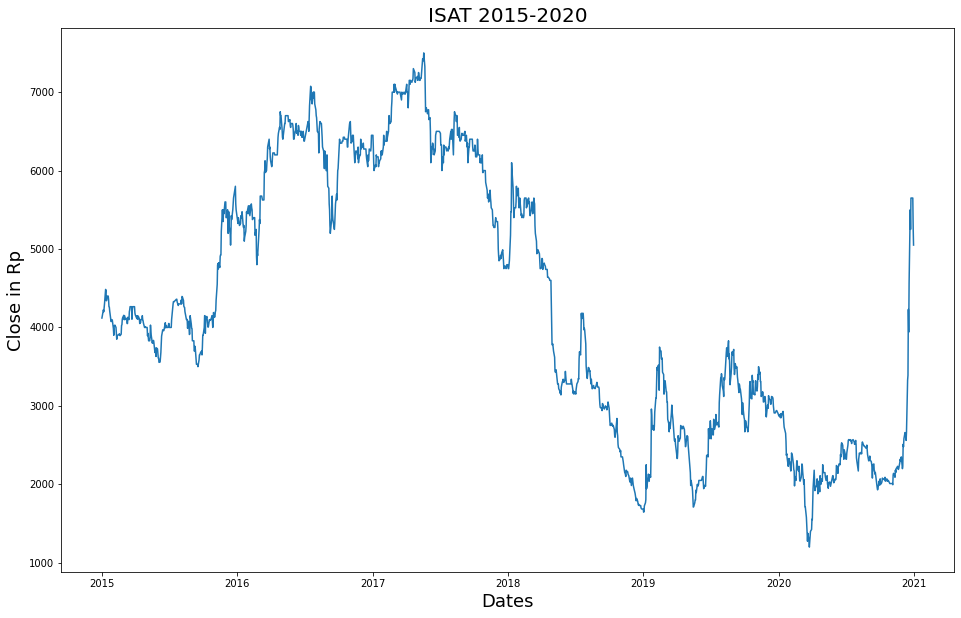

In [ ]:
# Visualization

plt.figure(figsize = (16,10))
plt.plot(df,'-')
plt.gcf()
plt.title('ISAT 2015-2020', fontsize=20)
plt.xlabel('Dates', fontsize=18)
plt.ylabel('Close in Rp', fontsize=18)
plt.show()

## DATA PREPOCESSING
---

In [ ]:
# Splitting data into training and testing
split_value = df.shape[0] * 0.8

df_train = df[:int(split_value)]
df_test = df[int(split_value):]

# Check the size of the data
# df.shape -> (rows, columns) / (number of data points, number of features/variables)
print("df_train: ", df_train.shape) # -> df_train: (1204,) -> Number of data points: 1204
print("df_test: ", df_test.shape)

df_train:  (1204,)
df_test:  (301,)


In [ ]:
df_train.head

<bound method NDFrame.head of Date
2015-01-02    4120.0
2015-01-05    4200.0
2015-01-06    4225.0
2015-01-07    4200.0
2015-01-08    4250.0
               ...  
2019-09-30    2850.0
2019-10-01    2830.0
2019-10-02    2670.0
2019-10-03    2700.0
2019-10-04    2810.0
Name: Close, Length: 1204, dtype: float64>

In [ ]:
df_test.head

<bound method NDFrame.head of Date
2019-10-07    2730.0
2019-10-08    2720.0
2019-10-09    2710.0
2019-10-10    2670.0
2019-10-11    2680.0
               ...  
2020-12-22    5250.0
2020-12-23    5650.0
2020-12-28    5650.0
2020-12-29    5275.0
2020-12-30    5050.0
Name: Close, Length: 301, dtype: float64>

In [ ]:
# Normalize data testing

scaler = sklearn.preprocessing.MinMaxScaler()
df_train_norm = scaler.fit_transform(df_train.values.reshape(-1,1))
df_train_norm = df_train_norm.flatten()
print("df_test_norm: ", df_train_norm.shape)

df_test_norm:  (1204,)


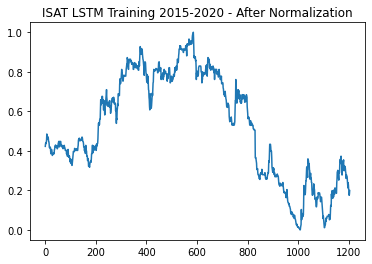

In [ ]:
# Visualize df_norm train
plt.plot(df_train_norm)
plt.title('ISAT LSTM Training 2015-2020 - After Normalization')
plt.show()

In [ ]:
# Normalize data testing

scaler = sklearn.preprocessing.MinMaxScaler()
df_test_norm = scaler.fit_transform(df_test.values.reshape(-1,1))
df_test_norm = df_test_norm.flatten()
print("df_test_norm: ", df_test_norm.shape)

df_test_norm:  (301,)


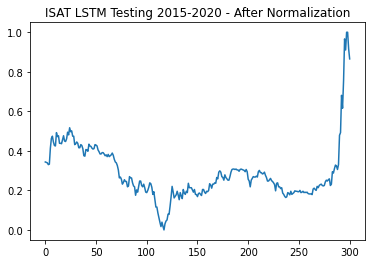

In [ ]:
# Visualize df_norm test
plt.plot(df_test_norm)
plt.title('ISAT LSTM Testing 2015-2020 - After Normalization')
plt.show()

## Prepare data for training
---
Note: Since we have already split the dataset into training and testing sets, the coding is slightly different. In the 'load_data' function, there is no step for splitting the data into train and test sets. Instead, the function will be run twice.

In [ ]:
# Build function to prepare dataset for training using LSTM

# Basic Concept:
# In the LSTM model, two variables X and Y are required
# "Y" is the predicted price value based on several previous prices (previous dates)
# "X" ais the predictor used to predict the value of "Y"
# Since the data is in sequence form (where there is no distinct "X" and "Y"), we need to create data for the X and Y variables

# Step 1: Determine the sequence length
# For example, if we have data [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] and we set the sequence length = 3,
# we will have 3 values for each "X"
# and 1 value for "Y", which is taken from the sequence after the 3rd "X" values

# X, y
# [1,2,3], [4]
# [2,3,4], [5]
# ...
# [7,8,9], [10]

# Step 2: Convert list -> matrix(array)
# Step 3: Reshape into 3D matrix form (number of rows "X" * sequence length * 1)


def load_data(data, seq_len):
    X = [] # Container for the "X" values
    y = [] # Container for the "Y" values

    # Create a loop from sequence length -> data length
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len : i])
        y.append(data[i])

    # convert to numpy array
    X = np.array(X)
    y = np.array(y)

    # reshape data to input into RNN models
    X = np.reshape(X, (X.shape[0], seq_len, 1))

    return [X, y]

In [ ]:
# Sequence length
seq_len = 100 # 5 values in the "X"

# Processed data
X_train_norm, y_train_norm = load_data(df_train_norm, seq_len) # For training data (using data that has already been normalized)

print('X_train.shape = ',X_train_norm.shape)
print('y_train.shape = ', y_train_norm.shape)

X_train.shape =  (1104, 100, 1)
y_train.shape =  (1104,)


## Base Model LSTM
---

**Build Model**
--
Note : This is the part where the 'parameters' can be changed to create a new model

In [ ]:
# Build Model LSTM

# Here, we try without using Dropout

# Settings for the model

name = "LSTM_base" # Nama for the model
neuron = 100 # Number of neurons in each hidden layer
opt = 'adam' # Method for the optimizer
loss = 'MSE' # Loss function used

#Build Model
lstm_model = Sequential(name=name)

lstm_model.add(LSTM(neuron,activation="tanh",return_sequences=True, input_shape=(X_train_norm.shape[1],1), name="HiddenLayer_1"))


lstm_model.add(LSTM(neuron,activation="tanh",return_sequences=True, name="HiddenLayer_2"))


lstm_model.add(LSTM(neuron,activation="tanh",return_sequences=False, name="HiddenLayer_3"))

lstm_model.add(Dense(1, name="OutputLayer"))

lstm_model.summary()

# Model Compile
lstm_model.compile(optimizer=opt,loss=loss)

Model: "LSTM_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HiddenLayer_1 (LSTM)        (None, 100, 100)          40800     
                                                                 
 HiddenLayer_2 (LSTM)        (None, 100, 100)          80400     
                                                                 
 HiddenLayer_3 (LSTM)        (None, 100)               80400     
                                                                 
 OutputLayer (Dense)         (None, 1)                 101       
                                                                 
Total params: 201,701
Trainable params: 201,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Settings for training
epochs = 200 # epoch
bz = 32 # bath_size

# Training model
history = lstm_model.fit(X_train_norm, y_train_norm, epochs=epochs, batch_size=bz)

Epoch 1/200
35/35 [==============================] - 26s 500ms/step - loss: 0.0401
Epoch 2/200
35/35 [==============================] - 16s 464ms/step - loss: 0.0040
Epoch 3/200
35/35 [==============================] - 15s 423ms/step - loss: 0.0030
Epoch 4/200
35/35 [==============================] - 8s 236ms/step - loss: 0.0028
Epoch 5/200
35/35 [==============================] - 9s 247ms/step - loss: 0.0024
Epoch 7/200
35/35 [==============================] - 8s 236ms/step - loss: 0.0029
Epoch 8/200
35/35 [==============================] - 9s 270ms/step - loss: 0.0020
Epoch 9/200
35/35 [==============================] - 8s 237ms/step - loss: 0.0019
Epoch 10/200
35/35 [==============================] - 8s 241ms/step - loss: 0.0016
Epoch 11/200
35/35 [==============================] - 9s 242ms/step - loss: 0.0017
Epoch 12/200
35/35 [==============================] - 11s 329ms/step - loss: 0.0016
Epoch 13/200
35/35 [==============================] - 9s 243ms/step - loss: 0.0015
Epoch 14

Evaluation
--

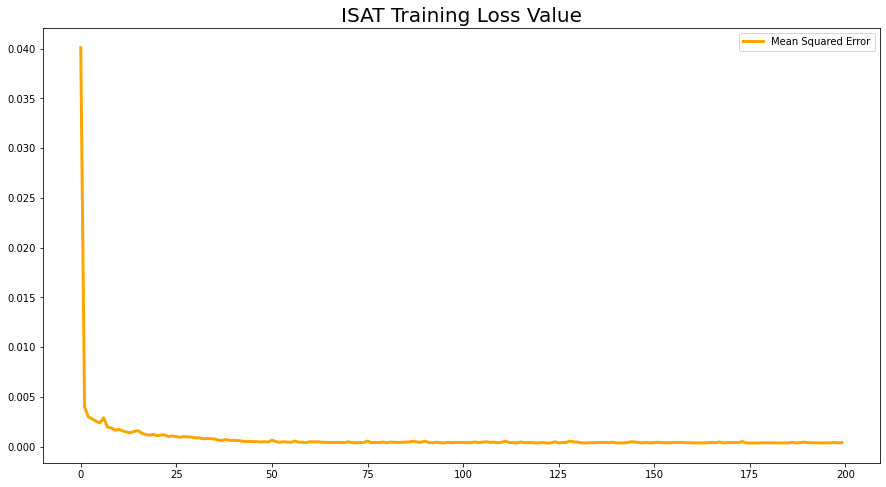

In [ ]:
plt.figure(figsize=(15,8))

plt.plot(history.history['loss'], c="orange", linewidth=3, label="Mean Squared Error")
plt.legend()
plt.title("ISAT Training Loss Value", fontsize=20)
plt.show()

## Prediction
---

In [ ]:
# Load data and create "X" and "y" from data testing

seq_len = 100

# Normalized data -> to be input into the model
X_train_norm, y_train_norm = load_data(df_train_norm, seq_len)
X_test_norm, y_test_norm = load_data(df_test_norm, seq_len)

# Original unnormalized data -> for evaluation
X_train, y_train = load_data(df_train, seq_len)
X_test, y_test = load_data(df_test, seq_len)

In [ ]:
# Prediction LSTM
lstm_predictions_training = lstm_model.predict(X_train_norm)
lstm_predictions_testing = lstm_model.predict(X_test_norm)

# Denormaization
lstm_denormalization_train = scaler.inverse_transform(lstm_predictions_training)
lstm_denormalization_test = scaler.inverse_transform(lstm_predictions_testing)

In [ ]:
train =  y_train
test =  y_test

predict_train = lstm_denormalization_train
predict_test = lstm_denormalization_test

predict_lstm_train_ISA14_1 = predict_train
predict_lstm_test_ISA14_1 = predict_test

In [ ]:
#predict data training lstm

data_train_lstm = df_train[100:1204]
data_train_lstm = pd.DataFrame({'Date':data_train_lstm.index, 'Close':data_train_lstm.values})
predict_lstm_train_ISA14_2 = pd.DataFrame(predict_lstm_train_ISA14_1, columns=['ISAT Predictions LSTM Training'])
predict_lstm_train_ISA14_3 = data_train_lstm.join(predict_lstm_train_ISA14_2)
predict_lstm_train_ISA14_3 = predict_lstm_train_ISA14_3.set_index('Date')
predict_lstm_train_ISA14_3

,Close,ISAT Predictions LSTM Training
Date,,
2015-05-28,3630.0,2797.197754
2015-05-29,3740.0,2717.749268
2015-06-01,3725.0,2797.823242
2015-06-03,3610.0,2790.233643
2015-06-04,3610.0,2699.602295
...,...,...
2019-09-30,2850.0,2212.348633
2019-10-01,2830.0,2114.452393
2019-10-02,2670.0,2089.007812


In [ ]:
#predict data testing lstm

data_test_lstm = df_test[100:301]
data_test_lstm = pd.DataFrame({'Date':data_test_lstm.index, 'Close':data_test_lstm.values})
predict_lstm_test_ISA14_2 = pd.DataFrame(predict_lstm_test_ISA14_1, columns=['ISAT Predictions LSTM Testing'])
predict_lstm_test_ISA14_3 = data_test_lstm.join(predict_lstm_test_ISA14_2)
predict_lstm_test_ISA14_3 = predict_lstm_test_ISA14_3.set_index('Date')
predict_lstm_test_ISA14_3

,Close,ISAT Predictions LSTM Testing
Date,,
2020-02-28,2040.0,2055.183350
2020-03-02,2090.0,2038.571533
2020-03-03,2160.0,2086.620117
2020-03-04,2260.0,2159.562256
2020-03-05,2240.0,2261.426758
...,...,...
2020-12-22,5250.0,5686.106445
2020-12-23,5650.0,5133.603027
2020-12-28,5650.0,5744.799316


In [ ]:
## LSTM training accuracy

lstm_score1 = r2_score(train, predict_train)
print("R2 Score train of LSTM model = ", lstm_score1)

lstm_score2 = mean_squared_error(train, predict_train)
print("MSE Score train of LSTM model = ", lstm_score2)

lstm_score3 = mean_absolute_error(train, predict_train)
print("MAE Score train of LSTM model = ", lstm_score3)

lstm_score4 = mean_squared_error(train, predict_train, squared=False)
print("RMSE Score train of LSTM model = ", lstm_score4)

lstm_score5 = mean_absolute_percentage_error(train, predict_train)
print("MAPE Score train of LSTM model = ", lstm_score5)

R2 Score train of LSTM model =  0.4331892910440215
MSE Score train of LSTM model =  1488161.7975798193
MAE Score train of LSTM model =  1159.1779075290847
RMSE Score train of LSTM model =  1219.9023721510748
MAPE Score train of LSTM model =  0.24591070344446617


In [ ]:
##LSTM testing accuracy

lstm_score1 = r2_score(test, predict_test)
print("R2 Score of LSTM model = ", lstm_score1)

lstm_score2 = mean_squared_error(test, predict_test)
print("MSE Score of LSTM model = ", lstm_score2)

lstm_score3 = mean_absolute_error(test, predict_test)
print("MAE Score of LSTM model = ", lstm_score3)

lstm_score4 = mean_squared_error(test, predict_test, squared=False)
print("RMSE Score of LSTM model = ", lstm_score4)

lstm_score5 = mean_absolute_percentage_error(test, predict_test)
print("MAPE Score of LSTM model = ", lstm_score5)

R2 Score of LSTM model =  0.953978587986914
MSE Score of LSTM model =  20738.012770575595
MAE Score of LSTM model =  80.58660129528141
RMSE Score of LSTM model =  144.00698861713482
MAPE Score of LSTM model =  0.032625653226493086


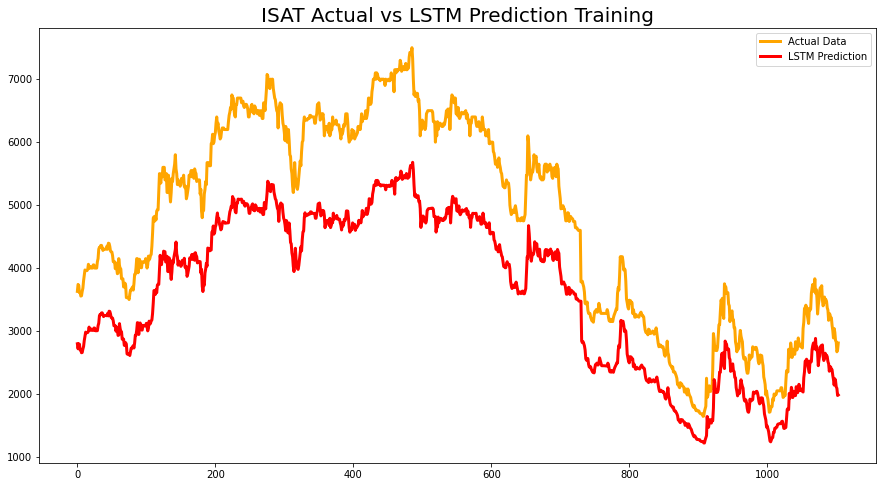

In [ ]:
##plot lstm training
plt.figure(figsize=(15,8))

plt.plot(y_train, c="orange", linewidth=3, label="Actual Data")
plt.plot(predict_train, c="red", linewidth=3, label="LSTM Prediction")
plt.legend()
plt.title("ISAT Actual vs LSTM Prediction Training", fontsize=20)
plt.show()

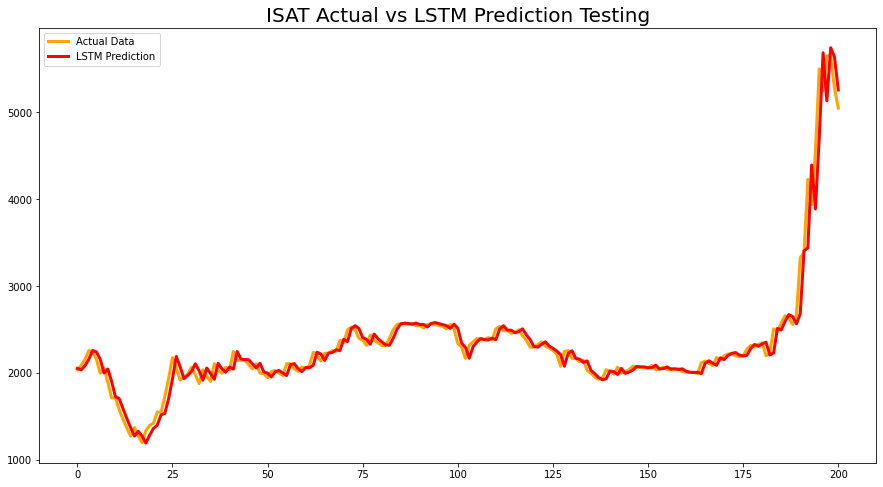

In [ ]:
##plot lstm training
plt.figure(figsize=(15,8))

plt.plot(y_test, c="orange", linewidth=3, label="Actual Data")
plt.plot(predict_test, c="red", linewidth=3, label="LSTM Prediction")
plt.legend()
plt.title("ISAT Actual vs LSTM Prediction Testing", fontsize=20)
plt.show()

---
### AUTO ARIMA
---

## Flow Autoarima

**Data Preparation**
check ADF -> Plot ACF

**Build Model**
Check the model with AutoARIMA

**Prediksi**
Make predictions with the best model from AutoARIMA

## Data Preparation
---

In [ ]:
# Splitting data into training and testing
split_value = df.shape[0] * 0.8

df_train = df[:int(split_value)]
df_test = df[int(split_value):]

# Check the size of the data
# df.shape -> (rows, columns) / (number of data points, number of features/variables)
print("df_train: ", df_train.shape) # -> df_train: (1204,) -> number of data points is 1204
print("df_test: ", df_test.shape)

df_train:  (1204,)
df_test:  (301,)


In [ ]:
df_train.head

<bound method NDFrame.head of Date
2015-01-02    4120.0
2015-01-05    4200.0
2015-01-06    4225.0
2015-01-07    4200.0
2015-01-08    4250.0
               ...  
2019-09-30    2850.0
2019-10-01    2830.0
2019-10-02    2670.0
2019-10-03    2700.0
2019-10-04    2810.0
Name: Close, Length: 1204, dtype: float64>

In [ ]:
df_test.head

<bound method NDFrame.head of Date
2019-10-07    2730.0
2019-10-08    2720.0
2019-10-09    2710.0
2019-10-10    2670.0
2019-10-11    2680.0
               ...  
2020-12-22    5250.0
2020-12-23    5650.0
2020-12-28    5650.0
2020-12-29    5275.0
2020-12-30    5050.0
Name: Close, Length: 301, dtype: float64>

In [ ]:
# Check if price training series is stationary

ADFTR = adfuller(df_train.dropna())
print(f"ADF Statistic: {ADFTR[0]}")
print(f"p-value: {ADFTR[1]}")

ADF Statistic: -1.210489210526651
p-value: 0.6690673203619893


In [ ]:
model = auto_arima(
    df_train,
    start_p=1,
    start_q=1,
    test="adf",
    max_p=5,
    max_q=5,
    m=1,  # frequency of series
    d=None,  # determine 'd'
    seasonal=False,  # no seasonality
    trace=True,
    stepwise=True,
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14581.367, Time=2.00 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14580.004, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14581.223, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14581.227, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14578.137, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.461 seconds


In [ ]:
model_train = sm.tsa.arima.ARIMA(df_train, order=(0, 1, 0))
result_train = model_train.fit()
print(result_train.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1204
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -7288.069
Date:                Tue, 16 Aug 2022   AIC                          14578.137
Time:                        11:07:19   BIC                          14583.230
Sample:                             0   HQIC                         14580.056
                               - 1204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.07e+04    208.452     51.320      0.000    1.03e+04    1.11e+04
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):              2296.78
Prob(Q):                              0.38   Pr

In [ ]:
model_test = sm.tsa.arima.ARIMA(df_test, order=(0, 1, 0))
result_test = model_test.fit()
print(result_test.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  301
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1882.801
Date:                Tue, 16 Aug 2022   AIC                           3767.603
Time:                        11:07:19   BIC                           3771.306
Sample:                             0   HQIC                          3769.085
                                - 301                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.655e+04    424.946     38.946      0.000    1.57e+04    1.74e+04
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):              4342.90
Prob(Q):                              0.67   Pr

## Prediction ARIMA
---

In [ ]:
predict_arima_train = result_train.predict(start=1, end=1203, dynamic=False)
predict_arima_train

Date
2015-01-05    4120.0
2015-01-06    4200.0
2015-01-07    4225.0
2015-01-08    4200.0
2015-01-09    4250.0
               ...  
2019-09-30    2980.0
2019-10-01    2850.0
2019-10-02    2830.0
2019-10-03    2670.0
2019-10-04    2700.0
Name: predicted_mean, Length: 1203, dtype: float64

In [ ]:
predict_arima_test = result_test.predict(start=1, end=300, dynamic=False)
predict_arima_test

Date
2019-10-08    2730.0
2019-10-09    2720.0
2019-10-10    2710.0
2019-10-11    2670.0
2019-10-14    2680.0
               ...  
2020-12-22    5500.0
2020-12-23    5250.0
2020-12-28    5650.0
2020-12-29    5650.0
2020-12-30    5275.0
Name: predicted_mean, Length: 300, dtype: float64

In [ ]:
data_train_arima = df_train[1:1204]
data_train_arima = pd.DataFrame({'Date':data_train_arima.index, 'Close':data_train_arima.values})
predict_arima_train_ISA14_1 = pd.DataFrame({'Date':predict_arima_train.index, 'ISAT Predictions ARIMA Training':predict_arima_train.values})
predict_arima_train_ISA14_2 = data_train_arima.set_index('Date').join(predict_arima_train_ISA14_1.set_index('Date'))
predict_arima_train_ISA14_2

,Close,ISAT Predictions ARIMA Training
Date,,
2015-01-05,4200.0,4120.0
2015-01-06,4225.0,4200.0
2015-01-07,4200.0,4225.0
2015-01-08,4250.0,4200.0
2015-01-09,4300.0,4250.0
...,...,...
2019-09-30,2850.0,2980.0
2019-10-01,2830.0,2850.0
2019-10-02,2670.0,2830.0


In [ ]:
data_test_arima = df_test[1:301]
data_test_arima = pd.DataFrame({'Date':data_test_arima.index, 'Close':data_test_arima.values})
predict_arima_test_ISA14_1 = pd.DataFrame({'Date':predict_arima_test.index, 'ISAT Predictions ARIMA Testing':predict_arima_test.values})
predict_arima_test_ISA14_2 = data_test_arima.set_index('Date').join(predict_arima_test_ISA14_1.set_index('Date'))
predict_arima_test_ISA14_2

,Close,ISAT Predictions ARIMA Testing
Date,,
2019-10-08,2720.0,2730.0
2019-10-09,2710.0,2720.0
2019-10-10,2670.0,2710.0
2019-10-11,2680.0,2670.0
2019-10-14,3040.0,2680.0
...,...,...
2020-12-22,5250.0,5500.0
2020-12-23,5650.0,5250.0
2020-12-28,5650.0,5650.0


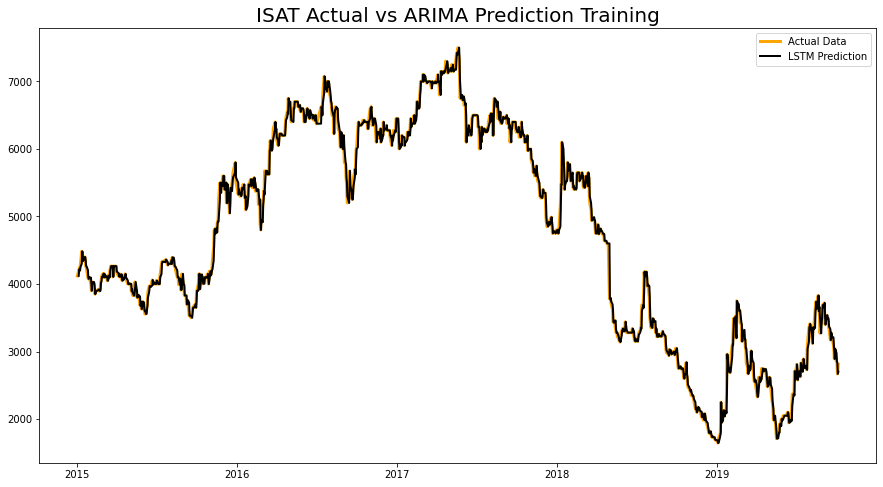

In [ ]:
##plot training ARIMA
plt.figure(figsize=(15,8))

plt.plot(df_train, c="orange", linewidth=3, label="Actual Data")
plt.plot(predict_arima_train, c="black", linewidth=2, label="LSTM Prediction")
plt.legend()
plt.title("ISAT Actual vs ARIMA Prediction Training", fontsize=20)
plt.show()

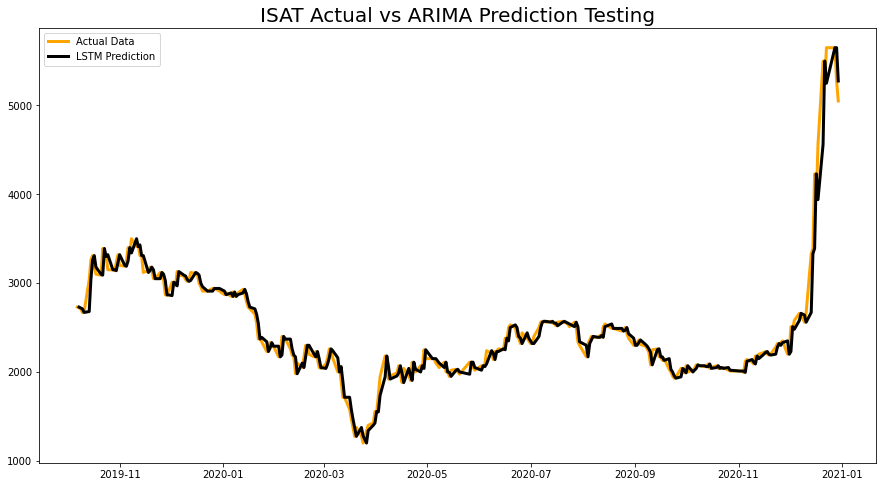

In [ ]:
##plot testing arima
plt.figure(figsize=(15,8))

plt.plot(df_test, c="orange", linewidth=3, label="Actual Data")
plt.plot(predict_arima_test, c="black", linewidth=3, label="LSTM Prediction")
plt.legend()
plt.title("ISAT Actual vs ARIMA Prediction Testing", fontsize=20)
plt.show()

In [ ]:
#akurasi train arima
train_arima = df_train[1:1204]

arima_score1 = r2_score(train_arima, predict_arima_train)
print("R2 Score train of ARIMA model = ", arima_score1)

arima_score2 = mean_squared_error(train_arima, predict_arima_train)
print("MSE Score train of ARIMA model = ", arima_score2)

arima_score3 = mean_absolute_error(train_arima, predict_arima_train)
print("MAE Score train of ARIMA model = ", arima_score3)

arima_score4 = mean_squared_error(train_arima, predict_arima_train, squared=False)
print("RMSE Score train of ARIMA model = ", arima_score4)

arima_score5 = mean_absolute_percentage_error(train_arima, predict_arima_train)
print("MAPE Score train of ARIMA model = ", arima_score5)

R2 Score train of ARIMA model =  0.9956243704721826
MSE Score train of ARIMA model =  10706.566916043224
MAE Score train of ARIMA model =  67.96342477140482
RMSE Score train of ARIMA model =  103.47254184585988
MAPE Score train of ARIMA model =  0.01606934803968406


In [ ]:
#akurasi test arima
test_arima = df_test[1:301]

arima_score1 = r2_score(test_arima, predict_arima_test)
print("R2 Score test of ARIMA model = ", arima_score1)

arima_score2 = mean_squared_error(test_arima, predict_arima_test)
print("MSE Score test of ARIMA model = ", arima_score2)

arima_score3 = mean_absolute_error(test_arima, predict_arima_test)
print("MAE Score test of ARIMA model = ", arima_score3)

arima_score4 = mean_squared_error(test_arima, predict_arima_test, squared=False)
print("RMSE Score test of ARIMA model = ", arima_score4)

arima_score5 = mean_absolute_percentage_error(test_arima, predict_arima_test)
print("MAPE Score test of ARIMA model = ", arima_score5)

R2 Score test of ARIMA model =  0.960292716537542
MSE Score test of ARIMA model =  16549.833333333332
MAE Score test of ARIMA model =  74.06666666666666
RMSE Score test of ARIMA model =  128.64615553265995
MAPE Score test of ARIMA model =  0.029092483911858754


## LSTM ARIMA
---

In [ ]:
#arima train
predict_arima_train_ISA14_3 = result_train.predict(start=100, end=1203, dynamic=False)
predict_arima_train_ISA14_4 = pd.DataFrame({'Date':predict_arima_train_ISA14_3.index, 'ISAT Predictions ARIMA Training':predict_arima_train_ISA14_3.values})

#lstm arima train
predict_lstm_arima_train_ISA14 = predict_lstm_train_ISA14_3.join(predict_arima_train_ISA14_4.set_index('Date'))
predict_lstm_arima_train_ISA14

,Close,ISAT Predictions LSTM Training,ISAT Predictions ARIMA Training
Date,,,
2015-05-28,3630.0,2797.197754,3735.0
2015-05-29,3740.0,2717.749268,3630.0
2015-06-01,3725.0,2797.823242,3740.0
2015-06-03,3610.0,2790.233643,3725.0
2015-06-04,3610.0,2699.602295,3610.0
...,...,...,...
2019-09-30,2850.0,2212.348633,2980.0
2019-10-01,2830.0,2114.452393,2850.0
2019-10-02,2670.0,2089.007812,2830.0


In [ ]:
#arima test
predict_arima_test_ISA14_3 = result_test.predict(start=100, end=300, dynamic=False)
predict_arima_test_ISA14_4 = pd.DataFrame({'Date':predict_arima_test_ISA14_3.index, 'ISAT Predictions ARIMA Testing':predict_arima_test_ISA14_3.values})

#lstm arima train
predict_lstm_arima_test_ISA14 = predict_lstm_test_ISA14_3.join(predict_arima_test_ISA14_4.set_index('Date'))
predict_lstm_arima_test_ISA14

,Close,ISAT Predictions LSTM Testing,ISAT Predictions ARIMA Testing
Date,,,
2020-02-28,2040.0,2055.183350,2050.0
2020-03-02,2090.0,2038.571533,2040.0
2020-03-03,2160.0,2086.620117,2090.0
2020-03-04,2260.0,2159.562256,2160.0
2020-03-05,2240.0,2261.426758,2260.0
...,...,...,...
2020-12-22,5250.0,5686.106445,5500.0
2020-12-23,5650.0,5133.603027,5250.0
2020-12-28,5650.0,5744.799316,5650.0


In [ ]:
## LSTM training accuracy

lstm_score1 = r2_score(train, predict_train)
print("R2 Score train of LSTM model = ", lstm_score1)

lstm_score2 = mean_squared_error(train, predict_train)
print("MSE Score train of LSTM model = ", lstm_score2)

lstm_score3 = mean_absolute_error(train, predict_train)
print("MAE Score train of LSTM model = ", lstm_score3)

lstm_score4 = mean_squared_error(train, predict_train, squared=False)
print("RMSE Score train of LSTM model = ", lstm_score4)

lstm_score5 = mean_absolute_percentage_error(train, predict_train)
print("MAPE Score train of LSTM model = ", lstm_score5)

R2 Score train of LSTM model =  0.4331892910440215
MSE Score train of LSTM model =  1488161.7975798193
MAE Score train of LSTM model =  1159.1779075290847
RMSE Score train of LSTM model =  1219.9023721510748
MAPE Score train of LSTM model =  0.24591070344446617


In [ ]:
#ARIMA training accuracy

arima_score1 = r2_score(train, predict_arima_train_ISA14_3)
print("R2 Score train of ARIMA model = ", arima_score1)

arima_score2 = mean_squared_error(train, predict_arima_train_ISA14_3)
print("MSE Score train of ARIMA model = ", arima_score2)

arima_score3 = mean_absolute_error(train, predict_arima_train_ISA14_3)
print("MAE Score train of ARIMA model = ", arima_score3)

arima_score4 = mean_squared_error(train, predict_arima_train_ISA14_3, squared=False)
print("RMSE Score train of ARIMA model = ", arima_score4)

arima_score5 = mean_absolute_percentage_error(train, predict_arima_train_ISA14_3)
print("MAPE Score train of ARIMA model = ", arima_score5)

R2 Score train of ARIMA model =  0.9956782998432143
MSE Score train of ARIMA model =  11346.625905797102
MAE Score train of ARIMA model =  70.13134057971014
RMSE Score train of ARIMA model =  106.52054217754011
MAPE Score train of ARIMA model =  0.016544925991065468


In [ ]:
##LSTM testing accuracy

lstm_score1 = r2_score(test, predict_test)
print("R2 Score of LSTM model = ", lstm_score1)

lstm_score2 = mean_squared_error(test, predict_test)
print("MSE Score of LSTM model = ", lstm_score2)

lstm_score3 = mean_absolute_error(test, predict_test)
print("MAE Score of LSTM model = ", lstm_score3)

lstm_score4 = mean_squared_error(test, predict_test, squared=False)
print("RMSE Score of LSTM model = ", lstm_score4)

lstm_score5 = mean_absolute_percentage_error(test, predict_test)
print("MAPE Score of LSTM model = ", lstm_score5)

R2 Score of LSTM model =  0.953978587986914
MSE Score of LSTM model =  20738.012770575595
MAE Score of LSTM model =  80.58660129528141
RMSE Score of LSTM model =  144.00698861713482
MAPE Score of LSTM model =  0.032625653226493086


In [ ]:
#ARIMA testing accuracy


arima_score1 = r2_score(test, predict_arima_test_ISA14_3)
print("R2 Score test of ARIMA model = ", arima_score1)

arima_score2 = mean_squared_error(test, predict_arima_test_ISA14_3)
print("MSE Score test of ARIMA model = ", arima_score2)

arima_score3 = mean_absolute_error(test, predict_arima_test_ISA14_3)
print("MAE Score test of ARIMA model = ", arima_score3)

arima_score4 = mean_squared_error(test, predict_arima_test_ISA14_3, squared=False)
print("RMSE Score test of ARIMA model = ", arima_score4)

arima_score5 = mean_absolute_percentage_error(test, predict_arima_test_ISA14_3)
print("MAPE Score test of ARIMA model = ", arima_score5)

R2 Score test of ARIMA model =  0.954992020413986
MSE Score test of ARIMA model =  20281.343283582093
MAE Score test of ARIMA model =  77.01492537313433
RMSE Score test of ARIMA model =  142.41258119836917
MAPE Score test of ARIMA model =  0.03126772651704256


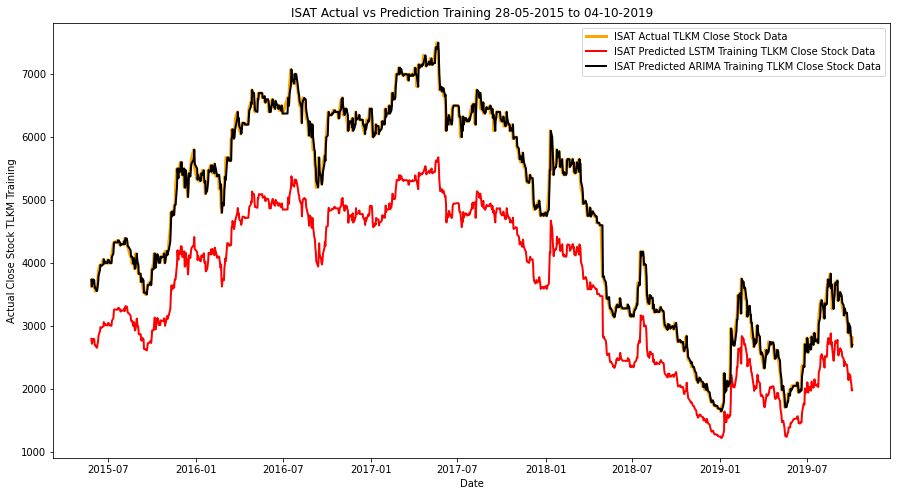

In [ ]:
#Visualisation Predict LSTM ARIMA Train
train_ISA14 = predict_lstm_arima_train_ISA14.Close
lstm_train_ISA14 = predict_lstm_arima_train_ISA14["ISAT Predictions LSTM Training"]
arima_train_ISA14 = predict_lstm_arima_train_ISA14["ISAT Predictions ARIMA Training"]

def plot_predictionscoba(clse, plstm, parima, title):
    plt.figure(figsize=(15,8))
    plt.plot(train_ISA14, linewidth=3, color='orange',label='ISAT Actual TLKM Close Stock Data')
    plt.plot(lstm_train_ISA14, linewidth=2, color='red',label='ISAT Predicted LSTM Training TLKM Close Stock Data')
    plt.plot(arima_train_ISA14, linewidth=2, color='black',label='ISAT Predicted ARIMA Training TLKM Close Stock Data')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Actual Close Stock TLKM Training')
    plt.legend()
    plt.show()
plot_predictionscoba(train_ISA14, lstm_train_ISA14, arima_train_ISA14, "ISAT Actual vs Prediction Training 28-05-2015 to 04-10-2019")

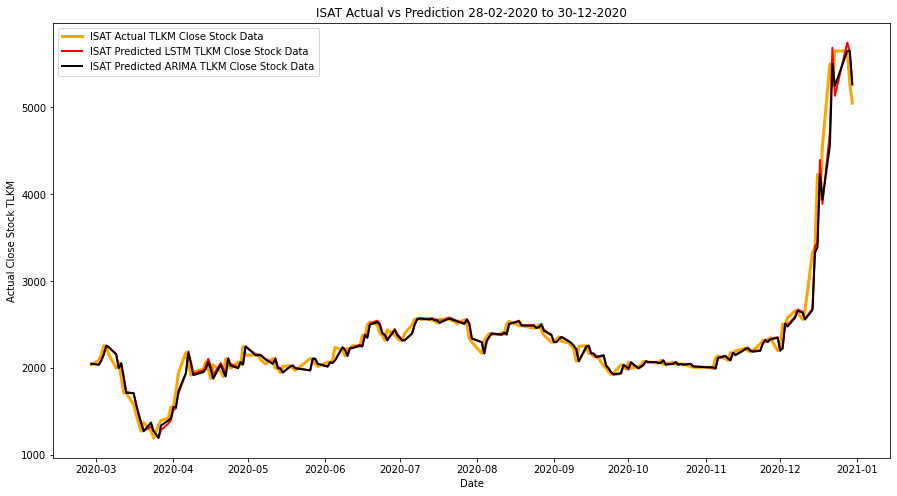

In [ ]:
#Visualisation Predict LSTM ARIMA Test
test_ISA14 = predict_lstm_arima_test_ISA14.Close
lstm_test_ISA14 = predict_lstm_arima_test_ISA14["ISAT Predictions LSTM Testing"]
arima_test_ISA14 = predict_lstm_arima_test_ISA14["ISAT Predictions ARIMA Testing"]

def plot_predictionscoba(clse, plstm, parima, title):
    plt.figure(figsize=(15,8))
    plt.plot(test_ISA14, linewidth=3, color='orange',label='ISAT Actual TLKM Close Stock Data')
    plt.plot(lstm_test_ISA14, linewidth=2, color='red',label='ISAT Predicted LSTM TLKM Close Stock Data')
    plt.plot(arima_test_ISA14, linewidth=2, color='black',label='ISAT Predicted ARIMA TLKM Close Stock Data')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Actual Close Stock TLKM')
    plt.legend()
    plt.show()
plot_predictionscoba(test_ISA14, lstm_test_ISA14, arima_test_ISA14, "ISAT Actual vs Prediction 28-02-2020 to 30-12-2020")

---
## File
---

Create a file from the prediction results

This step works for those using the application on a computer

In [ ]:
##data
dataused = pd.DataFrame({'Date':df.index, 'Close':df.values})
dataused = dataused.set_index('Date')
dataused.to_excel("D:\Python\Hasil\Python5\E10\Data Used.xlsx")
dataused = pd.read_excel("D:\Python\Hasil\Python5\E10\Data Used.xlsx")
dataused

,Date,Close
0,2015-01-02,2344.27
1,2015-01-05,2323.78
2,2015-01-06,2307.38
3,2015-01-07,2303.28
4,2015-01-08,2323.78
...,...,...
1500,2020-12-22,3085.84
1501,2020-12-23,3049.10
1502,2020-12-28,3150.13
1503,2020-12-29,3140.95


In [ ]:
#file predict data training lstm
predict_lstm_train_E10_3.to_excel("D:\Python\Hasil\Python5\E10\Predict Data Training LSTM.xlsx")
predict_lstm_train_E10_3 = pd.read_excel("D:\Python\Hasil\Python5\E10\Predict Data Training LSTM.xlsx")
predict_lstm_train_E10_3

,Date,Close,Predictions LSTM Training
0,2015-01-09,2344.27,2440.362061
1,2015-01-12,2323.78,2449.731445
2,2015-01-13,2327.87,2441.711914
3,2015-01-14,2315.58,2442.800049
4,2015-01-15,2319.68,2437.914795
...,...,...,...
1344,2020-05-06,2831.47,2725.708496
1345,2020-05-08,2787.77,2696.467773
1346,2020-05-11,2813.99,2676.837891
1347,2020-05-12,2752.81,2685.355469


In [ ]:
#file predict data testing lstm
predict_lstm_test_E10_3.to_excel("D:\Python\Hasil\Python5\E10\Predict Data Testing LSTM.xlsx")
predict_lstm_test_E10_3 = pd.read_excel("D:\Python\Hasil\Python5\E10\Predict Data Testing LSTM.xlsx")
predict_lstm_test_E10_3

,Date,Close,Predictions LSTM Testing
0,2020-05-26,2840.20,2774.841797
1,2020-05-27,2770.29,2837.265137
2,2020-05-28,2735.34,2773.565918
3,2020-05-29,2752.81,2743.172607
4,2020-06-02,2840.20,2757.115967
...,...,...,...
141,2020-12-22,3085.84,3230.173584
142,2020-12-23,3049.10,3081.946289
143,2020-12-28,3150.13,3064.074219
144,2020-12-29,3140.95,3162.147217


In [ ]:
#file predict data training arima
predict_arima_train_E10_2.to_excel("D:\Python\Hasil\Python5\E10\Predict Data Training ARIMA.xlsx")
predict_arima_train_E10_2 = pd.read_excel("D:\Python\Hasil\Python5\E10\Predict Data Training ARIMA.xlsx")
predict_arima_train_E10_2

,Date,Close,Predictions ARIMA Training
0,2015-01-05,2323.78,2343.984729
1,2015-01-06,2307.38,2324.000475
2,2015-01-07,2303.28,2310.087449
3,2015-01-08,2323.78,2304.494127
4,2015-01-09,2344.27,2324.676504
...,...,...,...
1348,2020-05-06,2831.47,2902.829749
1349,2020-05-08,2787.77,2825.065991
1350,2020-05-11,2813.99,2795.783442
1351,2020-05-12,2752.81,2815.982043


In [ ]:
#file predict data testing arima
predict_arima_test_E10_2.to_excel("D:\Python\Hasil\Python5\E10\Predict Data Testing ARIMA.xlsx")
predict_arima_test_E10_2 = pd.read_excel("D:\Python\Hasil\Python5\E10\Predict Data Testing ARIMA.xlsx")
predict_arima_test_E10_2

,Date,Close,Predictions ARIMA Testing
0,2020-05-15,2709.12,2682.633922
1,2020-05-18,2813.99,2705.962545
2,2020-05-19,2857.68,2805.568802
3,2020-05-20,2779.03,2837.519097
4,2020-05-26,2840.20,2788.060825
...,...,...,...
145,2020-12-22,3085.84,3224.382740
146,2020-12-23,3049.10,3058.451178
147,2020-12-28,3150.13,3080.356391
148,2020-12-29,3140.95,3155.706644


In [ ]:
#file predict data training lstm arima

predict_lstm_arima_train_E10.to_excel("D:\Python\Hasil\Python5\E10\Predict Data Training LSTM ARIMA.xlsx")
predict_lstm_arima_train_E10 = pd.read_excel("D:\Python\Hasil\Python5\E10\Predict Data Training LSTM ARIMA.xlsx")
predict_lstm_arima_train_E10

,Date,Close,Predictions LSTM Training,Predictions ARIMA Training
0,2015-01-09,2344.27,2440.362061,2324.676504
1,2015-01-12,2323.78,2449.731445,2342.574168
2,2015-01-13,2327.87,2441.711914,2323.238578
3,2015-01-14,2315.58,2442.800049,2329.546613
4,2015-01-15,2319.68,2437.914795,2314.159394
...,...,...,...,...
1344,2020-05-06,2831.47,2725.708496,2902.829749
1345,2020-05-08,2787.77,2696.467773,2825.065991
1346,2020-05-11,2813.99,2676.837891,2795.783442
1347,2020-05-12,2752.81,2685.355469,2815.982043


In [ ]:
#file predict data testing lstm arima

predict_lstm_arima_test_E10.to_excel("D:\Python\Hasil\Python5\E10\Predict Data Testing LSTM ARIMA.xlsx")
predict_lstm_arima_test_E10 = pd.read_excel("D:\Python\Hasil\Python5\E10\Predict Data Testing LSTM ARIMA.xlsx")
predict_lstm_arima_test_E10

,Date,Close,Predictions LSTM Testing,Predictions ARIMA Testing
0,2020-05-26,2840.20,2774.841797,2788.060825
1,2020-05-27,2770.29,2837.265137,2870.756871
2,2020-05-28,2735.34,2773.565918,2744.302415
3,2020-05-29,2752.81,2743.172607,2738.383434
4,2020-06-02,2840.20,2757.115967,2763.864944
...,...,...,...,...
141,2020-12-22,3085.84,3230.173584,3224.382740
142,2020-12-23,3049.10,3081.946289,3058.451178
143,2020-12-28,3150.13,3064.074219,3080.356391
144,2020-12-29,3140.95,3162.147217,3155.706644


---
## Special google colab
---

Create a file from the prediction results

This step works for those using Google Colab

In [ ]:
from google.colab import files

In [ ]:
##data
dataused = pd.DataFrame({'Date':df.index, 'Close':df.values})
dataused = dataused.set_index('Date')
dataused.to_excel("ISA14 Data Used.xlsx")
dataused = pd.read_excel("ISA14 Data Used.xlsx")
dataused

,Date,Close
0,2015-01-02,4120
1,2015-01-05,4200
2,2015-01-06,4225
3,2015-01-07,4200
4,2015-01-08,4250
...,...,...
1500,2020-12-22,5250
1501,2020-12-23,5650
1502,2020-12-28,5650
1503,2020-12-29,5275


In [ ]:
dataused.to_excel("ISA14 Data Used.xlsx")
files.download("ISA14 Data Used.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#file predict data training lstm
predict_lstm_train_ISA14_3.to_excel("ISA14 Predict Data Training LSTM.xlsx")
files.download("ISA14 Predict Data Training LSTM.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#file predict data testing lstm
predict_lstm_test_ISA14_3.to_excel("ISA14 Predict Data Testing LSTM.xlsx")
files.download("ISA14 Predict Data Testing LSTM.xlsx")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#file predict data training arima
predict_arima_train_ISA14_2.to_excel("ISA14 Predict Data Training ARIMA.xlsx")
files.download("ISA14 Predict Data Training ARIMA.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#file predict data testing arima
predict_arima_test_ISA14_2.to_excel("ISA14 Predict Data Testing ARIMA.xlsx")
files.download("ISA14 Predict Data Testing ARIMA.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#file predict data training lstm arima
predict_lstm_arima_train_ISA14.to_excel("ISA14 Predict Data Training LSTM ARIMA.xlsx")
files.download("ISA14 Predict Data Training LSTM ARIMA.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
 #file predict data testing lstm arima
predict_lstm_arima_test_ISA14.to_excel("ISA14 Predict Data Testing LSTM ARIMA.xlsx")
files.download("ISA14 Predict Data Testing LSTM ARIMA.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>